In [14]:
from glob import glob
from tqdm import tqdm

import os 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.utils.data import random_split
from torchvision.io import read_image

from torchvision import transforms as t
from torchvision.transforms import functional as F

import PIL

torch.backends.cudnn.benchmark = True

In [3]:
class SubsetTransforms(Dataset):
    def __init__(self, subset, transforms):
        self.subset = subset
        self.transforms = transforms
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transforms(x), y

    def __len__(self):
        return len(self.subset)

In [4]:
def verify_image(fp):
    try:
        PIL.Image.open(fp).verify()
        return True
    except:
        return False

In [5]:
def random_split_ratio(dataset, test_size=.2, random_state=None):
    L = len(dataset)
    n_second = int(L*test_size)
    n_first = L - n_second
    if random_state:
        first_split, second_split = random_split(dataset, lengths=[n_first, n_second], generator=torch.Generator().manual_seed(random_state))
    else:
        first_split, second_split = random_split(dataset, lengths=[n_first, n_second])

    return first_split, second_split

In [6]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        
        if isinstance(sample, tuple): # then it is in the form (x, y)
            sample, label = sample
            if isinstance(label, torch.TensorType):
                label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)

        axs[0, i].imshow(torchvision.transforms.functional.to_pil_image(sample))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

In [7]:
DATASET_PATH = 'C:/Users/Preinstall/Downloads/dataset'

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
transform = t.Compose([
    t.Resize((100, 100)),
    t.ToTensor(),
    t.ConvertImageDtype(torch.float32)
])

dataset = torchvision.datasets.ImageFolder(DATASET_PATH, is_valid_file=verify_image)
print(len(dataset))
training_dataset, test_dataset = random_split_ratio(dataset, random_state=42)
training_dataset, validation_dataset = random_split_ratio(training_dataset, random_state=42)

training_dataset = SubsetTransforms(training_dataset, transform)
print(len(training_dataset))
test_dataset = SubsetTransforms(test_dataset, transform)
print(len(test_dataset))
validation_dataset = SubsetTransforms(validation_dataset, transform)
print(len(validation_dataset))

30000
19200
6000
4800


In [10]:
def evaluate(dataset, model, device=device, **dataloader_args):
    dataloader = DataLoader(dataset, **dataloader_args)
    preds = []
    labels = []
    with torch.no_grad():
        model.eval()
        model.to(device)
        
        for x_batch, y_batch in tqdm(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.tolist()
            
            outs = model(x_batch).detach()
            predictions = torch.argmax(torch.softmax(outs, 1), 1).tolist()
            
            preds.extend(predictions)
            labels.extend(y_batch)
            
    report = classification_report(labels, preds, digits = 3)
    report_dict = classification_report(labels, preds, output_dict=True)
    
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Keys','Wheels'],
            yticklabels=['Keys','Wheels'])
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.show()
    
    print(report)
    
    return report_dict


In [11]:
def train(model, loss_fn, train_loader, val_loader, return_model=False,
          device=device, lr_adjuster=None, epochs=10):
    
    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)
    
    training_losses = []
    validation_losses = []
    validation_accuracies = []  
    
    optimizer = get_optimizer(model)
    model.to(device)

    print("Number of samples")
    print("Training:", n_train)
    print('Validation:', n_val)
    for epoch in range(epochs):
        epoch_training_running_loss = 0
        epoch_val_running_loss = 0

        
        bar = tqdm(enumerate(train_loader), total=n_train//train_loader.batch_size)
        for batch_idx, (x_batch, y_batch) in bar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            outs = model(x_batch)
            loss = loss_fn(outs, y_batch)
            loss.backward() 
            optimizer.step()
            optimizer.zero_grad()

            epoch_training_running_loss += (loss.item() * x_batch.size(0))

        with torch.no_grad():
            model.eval()
            vbar = tqdm(val_loader, total=n_val//val_loader.batch_size)
            val_predictions = []  
            val_targets = []  
            for x_batch, y_batch in vbar:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                outs = model(x_batch)
                loss = loss_fn(outs, y_batch)
                epoch_val_running_loss += (loss.item() * x_batch.size(0))
                
                
                val_predictions.extend(torch.argmax(outs, dim=1).cpu().numpy())
                val_targets.extend(y_batch.cpu().numpy())
                
            model.train()
        
        average_training_loss = epoch_training_running_loss / n_train
        average_validation_loss = epoch_val_running_loss / n_val

        training_losses.append(average_training_loss)
        validation_losses.append(average_validation_loss)
        
        
        validation_accuracy = accuracy_score(val_targets, val_predictions)
        validation_accuracies.append(validation_accuracy)
        if lr_adjuster:
            print(f"epoch {epoch+1}/{epochs}, lr={lr} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}, validation accuracy: {validation_accuracy:.3f}")
        else:
            print(f"epoch {epoch+1}/{epochs} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}, validation accuracy: {validation_accuracy:.3f}")
            
    if return_model:
        return training_losses, validation_losses, model
    else:
        return training_losses, validation_losses

In [12]:
labels_to_idx = {"Wheel":1, "Key":0}
idx_to_labels = {0: "Key", 1: "Wheel"}

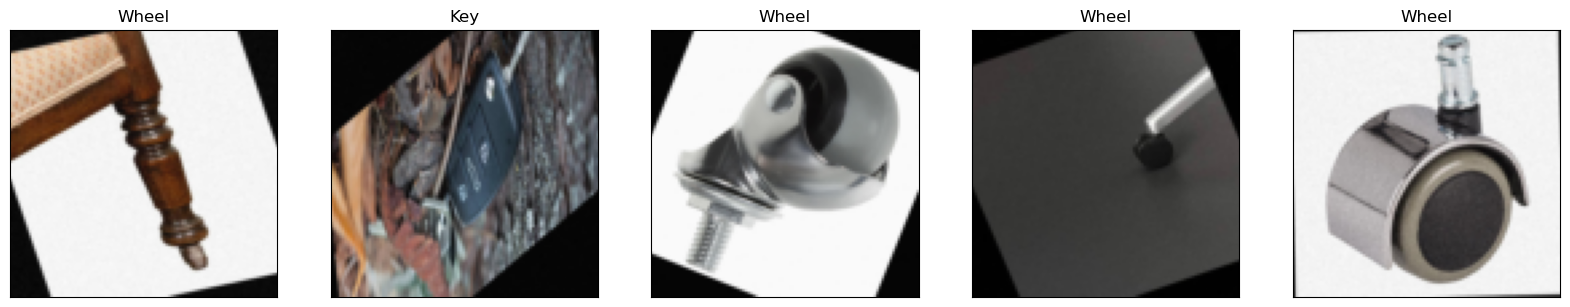

In [15]:
show(training_dataset, labels=idx_to_labels)

In [16]:
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8)
    return optimizer

def get_model():
    return Model()

In [21]:
MAX_FILTERS = 256
IMAGE_HEIGHT = 100     
IMAGE_WIDTH = 100
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),          
          nn.BatchNorm2d(64),                       
          nn.ReLU(),                               
          nn.MaxPool2d(2))                          
        
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, int(MAX_FILTERS/2), 3, padding=1),         
          nn.BatchNorm2d(int(MAX_FILTERS/2)),
          nn.ReLU(),
          nn.MaxPool2d(2))                          
        
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(int(MAX_FILTERS/2), MAX_FILTERS, 3, padding=1),        
          nn.BatchNorm2d(MAX_FILTERS),
          nn.ReLU(),
          nn.MaxPool2d(2))                          
        
        self.classifier = nn.Sequential(                    
          nn.Flatten(),                                     
          nn.Linear(in_features=MAX_FILTERS*int(IMAGE_WIDTH/8)*int(IMAGE_WIDTH/8), out_features=1024),
          nn.ReLU(),
          nn.Linear(in_features=1024, out_features=2)
          )   
        self.dropout = nn.Dropout2d(p=0.5)         
    
    
    def forward(self, x: torch.Tensor):                     
        
        x = self.conv_layer_1(x)              
        x = self.conv_layer_2(x)
        x = self.dropout(x)                   
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x

In [22]:
model = CNN()

#model = torch.load(r'C:\Users\Preinstall\Downloads\OriginalClassifier.pth')

Number of samples
Training: 19200
Validation: 4800


100%|██████████| 75/75 [04:32<00:00,  3.63s/it]
19it [01:03,  3.36s/it]                        


epoch 1/10, lr=1e-3 | avg. training loss: 0.009, avg. validation loss: 0.011, validation accuracy: 0.998


100%|██████████| 75/75 [04:31<00:00,  3.62s/it]
19it [01:04,  3.37s/it]                        


epoch 2/10, lr=1e-3 | avg. training loss: 0.010, avg. validation loss: 0.013, validation accuracy: 0.996


100%|██████████| 75/75 [04:41<00:00,  3.75s/it]
19it [01:04,  3.40s/it]                        


epoch 3/10, lr=1e-3 | avg. training loss: 0.009, avg. validation loss: 0.016, validation accuracy: 0.996


100%|██████████| 75/75 [04:32<00:00,  3.64s/it]
19it [01:04,  3.38s/it]                        


epoch 4/10, lr=1e-3 | avg. training loss: 0.007, avg. validation loss: 0.009, validation accuracy: 0.997


100%|██████████| 75/75 [04:32<00:00,  3.63s/it]
19it [01:04,  3.37s/it]                        


epoch 5/10, lr=1e-3 | avg. training loss: 0.007, avg. validation loss: 0.012, validation accuracy: 0.997


100%|██████████| 75/75 [04:32<00:00,  3.64s/it]
19it [01:04,  3.39s/it]                        


epoch 6/10, lr=1e-3 | avg. training loss: 0.007, avg. validation loss: 0.010, validation accuracy: 0.997


100%|██████████| 75/75 [04:33<00:00,  3.64s/it]
19it [01:04,  3.37s/it]                        


epoch 7/10, lr=1e-3 | avg. training loss: 0.007, avg. validation loss: 0.012, validation accuracy: 0.997


100%|██████████| 75/75 [04:32<00:00,  3.64s/it]
19it [01:04,  3.42s/it]                        


epoch 8/10, lr=1e-3 | avg. training loss: 0.005, avg. validation loss: 0.009, validation accuracy: 0.998


100%|██████████| 75/75 [04:33<00:00,  3.64s/it]
19it [01:04,  3.40s/it]                        


epoch 9/10, lr=1e-3 | avg. training loss: 0.007, avg. validation loss: 0.009, validation accuracy: 0.997


100%|██████████| 75/75 [04:31<00:00,  3.62s/it]
19it [01:03,  3.36s/it]                        

epoch 10/10, lr=1e-3 | avg. training loss: 0.007, avg. validation loss: 0.010, validation accuracy: 0.997


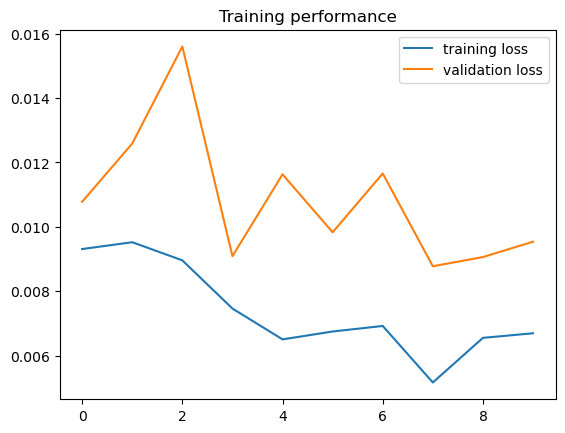

In [34]:
def adjust_lr(optimizer, epoch):
    if epoch < 10:
        lr = 1e-3
    elif epoch < 20:
        lr = 1e-4
    elif epoch < 30:
        lr = 1e-5
    else:
        lr = 6e-6
    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
        
train_loader = DataLoader(training_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_loss, validation_loss, model = train(model, loss_fn, train_loader, val_loader, 
                                              lr_adjuster=adjust_lr, return_model=True, device=device, epochs=40)

plt.title('Training performance')
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()
plt.show()

Training report


100%|██████████| 75/75 [04:16<00:00,  3.42s/it]


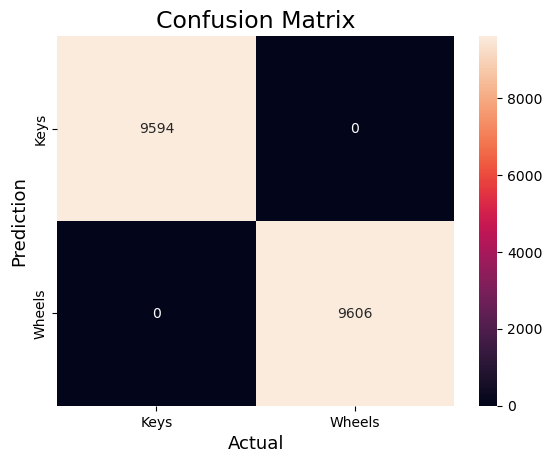

              precision    recall  f1-score   support

           0      1.000     1.000     1.000      9594
           1      1.000     1.000     1.000      9606

    accuracy                          1.000     19200
   macro avg      1.000     1.000     1.000     19200
weighted avg      1.000     1.000     1.000     19200



In [35]:
print("Training report")
training_report = evaluate(training_dataset, model, device=device, batch_size=256)

Validation report


100%|██████████| 19/19 [01:04<00:00,  3.37s/it]


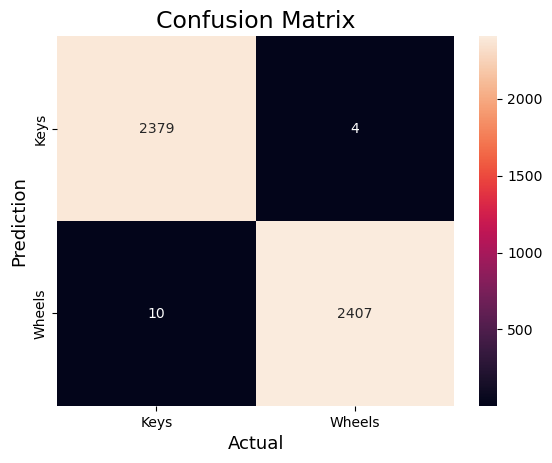

              precision    recall  f1-score   support

           0      0.996     0.998     0.997      2383
           1      0.998     0.996     0.997      2417

    accuracy                          0.997      4800
   macro avg      0.997     0.997     0.997      4800
weighted avg      0.997     0.997     0.997      4800



In [36]:
print("Validation report")
validation_report = evaluate(validation_dataset, model, device=device, batch_size=256)

Test report


100%|██████████| 24/24 [01:22<00:00,  3.43s/it]


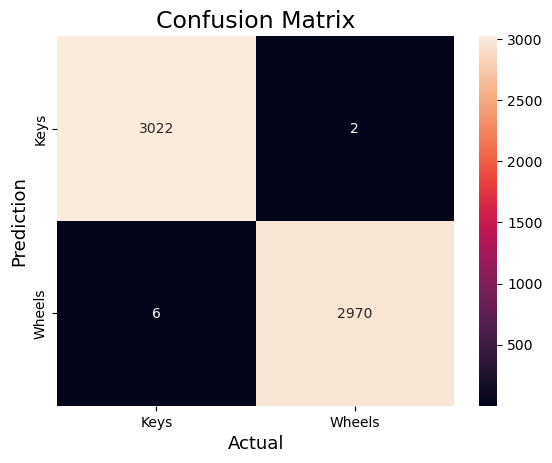

              precision    recall  f1-score   support

           0      0.998     0.999     0.999      3024
           1      0.999     0.998     0.999      2976

    accuracy                          0.999      6000
   macro avg      0.999     0.999     0.999      6000
weighted avg      0.999     0.999     0.999      6000



In [37]:
print("Test report")
test_report = evaluate(test_dataset, model, device=device, batch_size=256)